In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from os import listdir

rcParams = {'font.size': 20, 
            'font.weight': 'normal', 
            'font.family': 'sans-serif',
            'axes.unicode_minus':False, 
            'axes.labelweight':'normal', 
            'xtick.labelsize' : 16,
            'ytick.labelsize' : 16}

plt.rcParams.update(rcParams)

def Parse_Diff_Read_Alignment_Summary(fp):
    lines = open(fp).readlines()
    d = {}
    for l in lines:
        l = l.replace("\n","").split("\t")
        d[l[0]] = int(l[2])
    return d

def Plot_Box_Plots(boxes, positions, colors, ax, widths = 0.45, lw = 3.5, 
                   scatter = True, deviation = 0.045, s = 70, alpha = 0.1):
    flierprops = dict(marker='x', markersize=0.5, linestyle='none')
    whiskerprops = dict(color='black',linewidth=1.5)
    capprops = dict(color='black', linewidth=0.5)
    medianprops = dict(linewidth=1.5, linestyle='-', color='black')
    box = ax.boxplot(boxes, positions=positions, whis = [5,95], widths = [widths]*len(positions),
                     showfliers = False, boxprops = dict(linestyle='-', linewidth=lw, color='black'), 
                     flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                     medianprops = medianprops)
    
    if(scatter):
        for i in range(0, len(positions)):
            y = boxes[i]
            x = np.random.normal(positions[i], deviation, size=len(y))
            ax.scatter(x,y,color = colors[i],alpha = alpha, marker = 'o', s = s)
            ax.scatter([positions[i]]*2, [max(y), min(y)], color = colors[i], marker = 'o', s = s)
            
def Get_NGx(lengths, cumulative, X=50):
    total_length = np.sum(lengths)
    i = cumulative[cumulative <= X*total_length/100]
    return lengths[len(i)]


In [3]:
cov_path = '/Users/harihara/Research-Activities/Data/Hot-Spring/Average_Coverage.pkl'
Average_Coverages = pkl.load(open(cov_path,'rb'))
genomes = sorted(list(Average_Coverages.keys()))

In [4]:
data_dir= '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/Hotsprings_Variant_Structure/'
op = []

for g in genomes:
    hot_springs = listdir(data_dir+g+'/')
    for h in hot_springs:
        if h.startswith("."):
            continue
        try:
            summary_file = data_dir+g+'/'+h+'/Differential_Read_Counting/Genome.'+g+'.Summary'
            d = Parse_Diff_Read_Alignment_Summary(summary_file)
            d['Genome'] = g
            d['Hotspring'] = h.replace("_FD","")
            op.append(d)
        except FileNotFoundError:
            print(g, h)

df_diff_read_count = pd.DataFrame(data = op)
df_diff_read_count['Orphaned_Reads'] = (df_diff_read_count['Orphaned Reads in Both Genomes'] + 
                                        df_diff_read_count['Orphaned Reads in Only One Genome '])
df_diff_read_count['Mispaired_Reads'] = (df_diff_read_count['Mispaired Reads in Both Genomes'] + 
                                         df_diff_read_count['Mispaired Reads in Only One Genome '])
df_diff_reads_sum = df_diff_read_count[['Genome', 'Hotspring', 'Orphaned_Reads', 'Mispaired_Reads']]
df_diff_reads_sum = df_diff_reads_sum.set_index(['Genome','Hotspring'])
op = []
lines = open('/Users/harihara/Research-Activities/Data/Hot-Spring/Bed_Counts.txt').readlines()
for l in lines:
    l = l.replace("\n","").split( )
    count = l[0]
    f = l[1].split('/')
    d = {'Genome':f[0], 'Hotspring':f[1].replace("_FD",""), 'Counts':int(count)}
    op.append(d)
df_counts = pd.DataFrame(op)
df_counts = df_counts.set_index(['Genome', 'Hotspring'])
df_diff_reads_sum = df_diff_reads_sum.join(df_counts)
df_diff_reads_sum['Frac_Orphaned'] = df_diff_reads_sum['Orphaned_Reads']/df_diff_reads_sum['Counts']*100.0
df_diff_reads_sum = df_diff_reads_sum.reset_index().pivot_table(index = 'Hotspring', columns = 'Genome', 
                                                                values = 'Frac_Orphaned')

Chloroflexus_MS_G Prokka_Annotations
OSA Prokka_Annotations
OSB Prokka_Annotations


In [4]:
data_dir= '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/Hotsprings_Variant_Structure/'
ref_dir = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/Data/YNP_Hot_Springs/\
Ref_Genomes_Not_Syn/'

N50 = {}
for k in range(len(genomes)):
    g = genomes[k]
    hot_springs = listdir(data_dir+g+'/')
    if g == 'OSA': genome_length = ref_dir+'Synechococcus_OS-A_genome.fasta.fai'
    elif g == 'OSB': genome_length = ref_dir+'Synechococcus_OS-B_genome.fasta.fai'
    else: genome_length = ref_dir+g+'.fna.fai'
    df_len = pd.read_csv(genome_length, names = ['Contig', 'Length', '1','2','3','4'], sep = "\t")
    glen = df_len['Length'].sum()
    
    d = {}
    for h in hot_springs:
        if h.startswith("Hot"): 
            contigs_len_path = data_dir+g+'/'+h+'/Megahit_Contigs/final.contigs.fa.fai'
            df = pd.read_csv(contigs_len_path, names = ['Contig', 'Length', '1','2','3','4'], sep = "\t")
            df = df.sort_values(by = ['Length'], ascending = False)
            x, y = df['Length'].tolist(), np.cumsum(df['Length'].tolist())
            d[h.replace("_FD","")] = (x, y, glen)
    N50[g] = d
    print(g, glen)

Aerophilum 3425982
Chloracidobacterium_thermophilum_B 3695372
Chloroflexus_MS_G 4770266
OSA 2932766
OSB 3046682
Roseiflexus 5801598


In [5]:
df_Metadata = pd.read_csv('/Users/harihara/Research-Activities/Data/Hot-Spring/hotspring_metadata.csv', 
                              sep = ",")
df_Metadata = df_Metadata.sort_values(by = ['Spring_Name','SampleID'])
samples = df_Metadata['SampleID'].tolist()
ms = len(df_Metadata[df_Metadata['Spring_Name'] == 'Mushroom'])
os = len(df_Metadata[df_Metadata['Spring_Name'] == 'Octopus'])

sample_spring = dict(zip(df_Metadata.index.tolist(), df_Metadata.Spring_Name.tolist()))
x_ticks = []
for s in samples:
    s = s.replace("Hotspr20Sample","").replace("Hotspr2Sample","").replace("HotsprSample","")\
         .replace("HotsprSampl","").replace("HotsprSamp","").replace("Hotspr","")
    x_ticks.append(s)
    
colors = ['red']*ms+['blue']*os

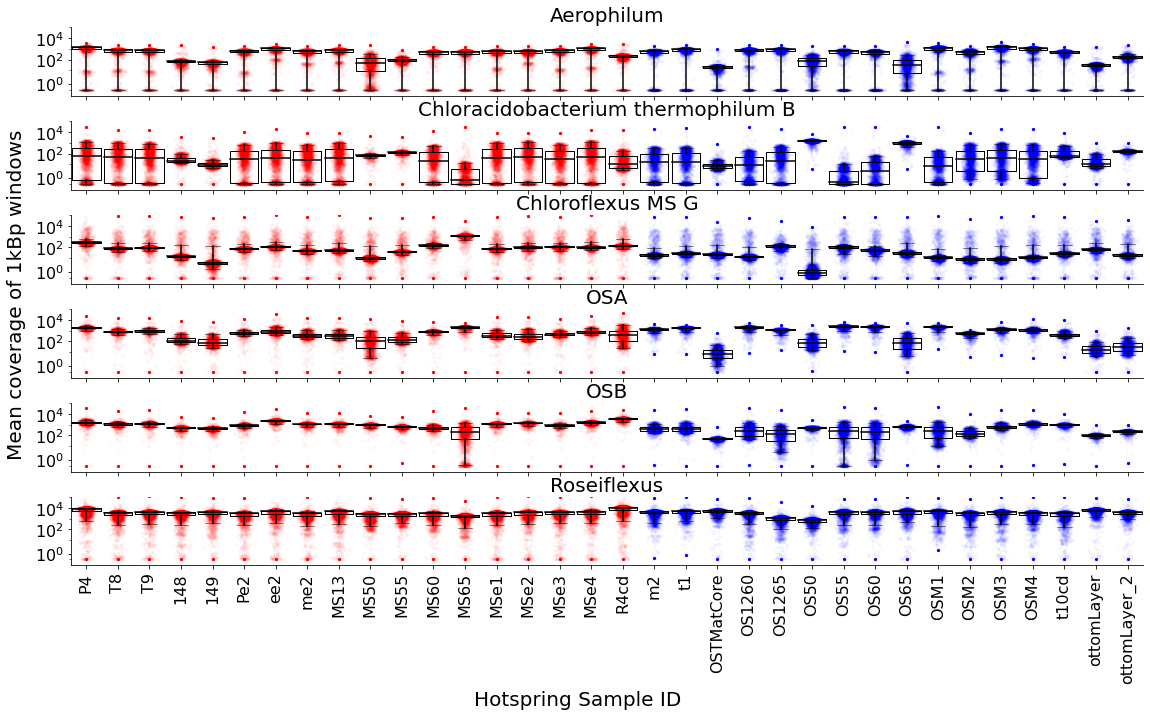

In [46]:
plt.rcParams.update(rcParams)

fig, ax = plt.subplots(6,1, figsize=(16,10), sharex = True)
for i in range(len(genomes)):
    g = genomes[i]

    boxes = list(Average_Coverages[g][samples].T.values)
    positions = list(range(0, 34))

    Plot_Box_Plots(boxes, positions, colors, ax[i], widths = 0.9, lw = 1.0, scatter = True, deviation = 0.095, 
                   s = 5, alpha = 0.025)
    ax[i].set_yscale('symlog')
    ax[i].set_yticks([1,100,10000])
    ax[i].set_ylim([-1, 100000])
    ax[i].set_title(g.replace("_"," "), size = 20)
    ax[i].set_xticks([])
    #ax[i].set_xlim([-0.5,33.5])
    ax[i].spines[['right', 'top']].set_visible(False)
ax[5].set_xticks(range(0, 34))
ax[5].set_xticklabels(x_ticks, rotation = 90)
fig.text(0.4, 0, 'Hotspring Sample ID')
fig.text(-0.005, 0.57, 'Mean coverage of 1kBp windows', 
         va='center', rotation='vertical')
fig.tight_layout()
fig.subplots_adjust(hspace = 0.375)

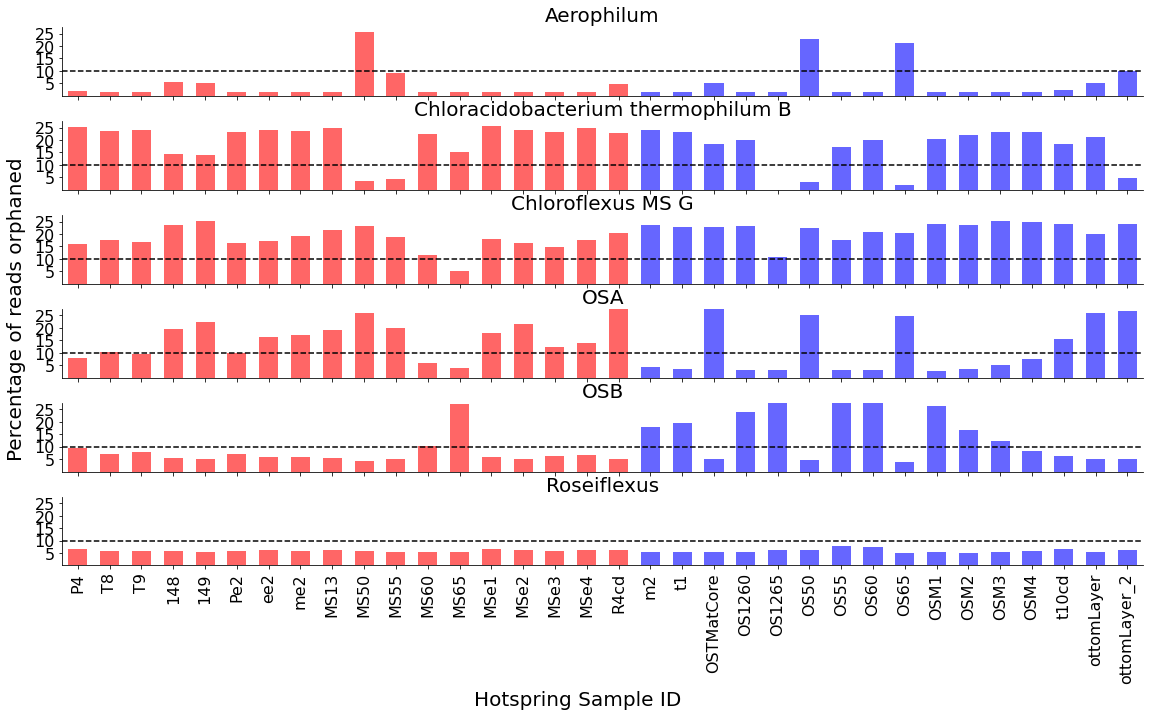

In [44]:
plt.rcParams.update(rcParams)

fig, ax = plt.subplots(6,1, figsize =(16,10), sharex = True)
for i in range(len(genomes)): 
    bars = ax[i].bar(range(0,34), df_diff_reads_sum.loc[samples][genomes[i]], width = 0.6, color = colors, 
                     alpha = 0.6)
    ax[i].set_title(genomes[i].replace("_"," "), size = 20)
    ax[i].set_ylim([0,27.5])
    ax[i].set_yticks([5,10,15,20,25])
    ax[i].set_xlim([-0.5,33.5])
    ax[i].set_xticks(range(0, 34))
    ax[i].axhline(10, linestyle = '--', color = 'black')
    ax[i].spines[['right', 'top']].set_visible(False)

ax[5].set_xticklabels(x_ticks, rotation = 90)

fig.text(0.4, 0, 'Hotspring Sample ID')
fig.text(-0.005, 0.55, 'Percentage of reads orphaned', va='center', rotation='vertical')

fig.tight_layout()
fig.subplots_adjust(hspace = 0.375)

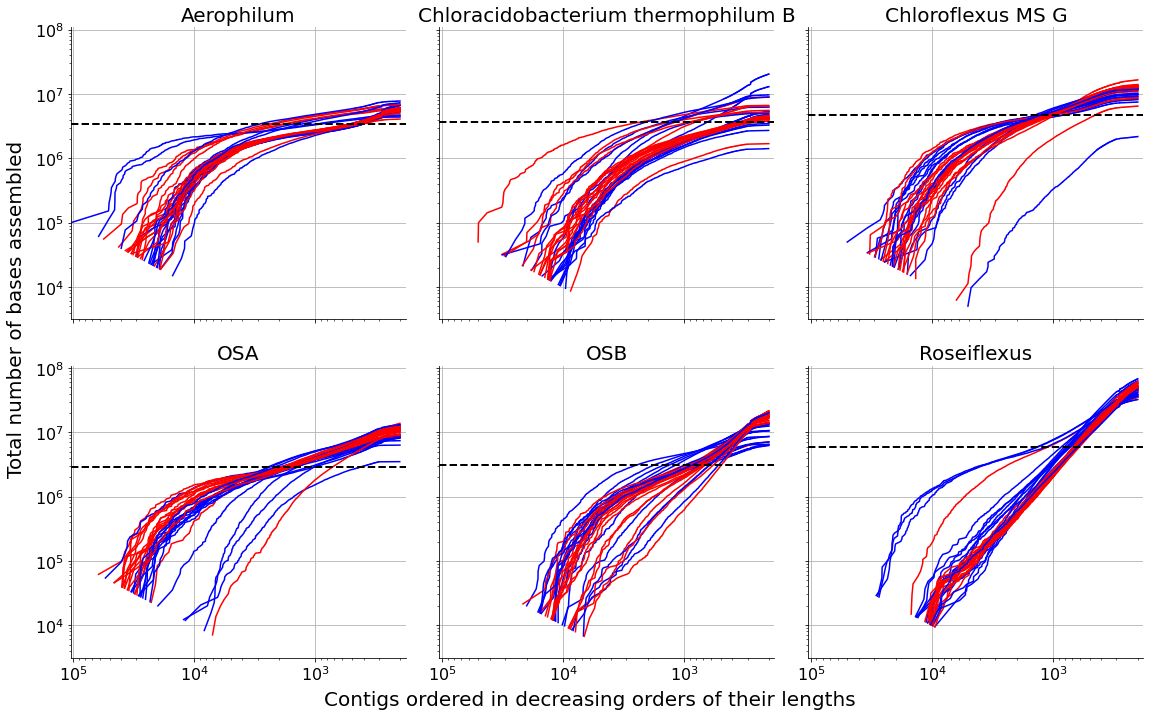

In [45]:
sample_dict = dict(zip(df_Metadata['SampleID'].tolist(), df_Metadata['Spring_Name'].tolist()))
fig, ax = plt.subplots(2, 3, figsize = (16, 10), sharex = False, sharey = True)
for k in range(len(genomes)):
    i, j = int(k/3), int(k%3)
    g = genomes[k]
    hot_springs = N50[g].keys()
    for h in hot_springs:
        if sample_dict[h] == 'Mushroom': color = 'red'
        else: color = 'blue'
        ax[i][j].plot(N50[g][h][0], N50[g][h][1], color = color)
    ax[i][j].set_title(g.replace("_"," "), size = 20)
    ax[i][j].set_yscale('log')
    ax[i][j].set_xscale('log')
    ax[i][j].set_xlim(ax[i][j].get_xlim()[::-1])
    ax[i][j].set_xlim([105000, 180])
    ax[i][j].axhline(N50[g][h][2], color = 'black', linestyle = '--', linewidth = 2)
    ax[i][j].grid()
    ax[i][j].spines[['right', 'top']].set_visible(False)

    if i == 0:
        ax[i][j].set_xticklabels([])
fig.text(0.27, 0, 'Contigs ordered in decreasing orders of their lengths')
fig.text(-0.005, 0.55, 'Total number of bases assembled', va='center', rotation='vertical')

fig.tight_layout()

In [17]:
from os.path import isfile

for f in listdir(data_dir+'Roseiflexus'):
    if f.startswith('Hot'):
        if not isfile(data_dir+'Roseiflexus/'+f+'/Differential_Read_Counting/Roseiflexus.Orphaned_Reads.Summary'):
            print(f)

HotsprSampleR4cd_FD
